In [47]:
#Lets consider the example of a product

#Product - https://www.flipkart.com/foscam-fi8910w-black-smart-security-camera/p/itmecqqxbc6xxz2m

Review scarpping will be seen in the upcoming one. At the moment, we will use the Excel file created from scraped data.




In [48]:
#importing the required libraries
import spacy
nlp = spacy.load('en_core_web_sm')

import gensim

import pandas as pd
from gensim import corpora

import re

In [49]:
#loading the reviews file
reviews = pd.read_csv('/content/reviews.csv')

In [50]:
reviews.shape

(4652, 14)

In [51]:
#Classifying the reviews
reviews['star_rating'] = reviews['star_rating'].apply(lambda x:1 if x > 3 else 0)

In [52]:
#Assigning 3 or less than it as negative ratings
negative_sentiments = reviews[reviews['star_rating'] == 0]

#print(negative_sentiments.shape[0])

In [53]:
negative_sentiments.head(2)

,Unnamed: 0,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,0,US,41099022,R59VGL4HIPFDP,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,1,N,Y,One Star,garbage,31-08-2015
1,1,US,15744366,R3GR0Z9Z4Z1295,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,0,N,N,Doesn't work as advertised,"Didn't work as advertised, there was no sound ...",31-08-2015


In [54]:
#combining the review heading and its body
negative_sentiments['Final review'] = negative_sentiments['review_headline'] + ' ' + negative_sentiments['review_body']

#removing the regular expressions
negative_sentiments['Final review'] = negative_sentiments['Final review'].str.replace("[^a-zA-Z#]", " ")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [55]:
#dropping the null values
negative_sentiments = negative_sentiments.dropna()

In [56]:
#tokenization and stop words removal
negative_sentiments['Final Text'] = ''
for i in range(negative_sentiments.shape[0]):
    temp = []
    document = nlp(negative_sentiments['Final review'].iloc[i].lower())
    for j in document:
        if j.is_stop!=True and j.is_punct!=True:
            temp.append(j.lemma_)
    negative_sentiments['Final Text'].iloc[i] = temp


/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [57]:
#vectoriazation and topic modeling 
def topic_modelling(text):
    dictionary = corpora.Dictionary(text)
    doc_term_matrix = [dictionary.doc2bow(rev) for rev in text]
    LDA = gensim.models.ldamodel.LdaModel
    lda_model = LDA(corpus = doc_term_matrix, id2word = dictionary, 
                    num_topics = 1, random_state = 19, passes = 50)
    temp = re.findall('[a-z]*',lda_model.print_topics()[0][1])
    tags = [x for x in temp if x]
    return tags

In [58]:
#getting the final text
negative_sentiments['Final Text'] = negative_sentiments['Final Text'].apply(lambda x:' '.join(x))
negative_sentiments.head(2)

,Unnamed: 0,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Final review,Final Text
0,0,US,41099022,R59VGL4HIPFDP,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,1,N,Y,One Star,garbage,31-08-2015,One Star garbage,star garbage
1,1,US,15744366,R3GR0Z9Z4Z1295,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,0,N,N,Doesn't work as advertised,"Didn't work as advertised, there was no sound ...",31-08-2015,Doesn t work as advertised Didn t work as adve...,doesn t work advertise didn t work advertise ...


In [59]:
#pandas
negative_sentiments['Review Tags'] = negative_sentiments['Final Text'].apply(lambda x: topic_modelling([x.split(' ')]))
negative_sentiments.head(2)

,Unnamed: 0,marketplace,customer_id,review_id,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,Final review,Final Text,Review Tags
0,0,US,41099022,R59VGL4HIPFDP,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,1,N,Y,One Star,garbage,31-08-2015,One Star garbage,star garbage,"[garbage, star]"
1,1,US,15744366,R3GR0Z9Z4Z1295,Foscam FI8910W Wireless/Wired Pan & Tilt IP/Ne...,Camera,0,0,0,N,N,Doesn't work as advertised,"Didn't work as advertised, there was no sound ...",31-08-2015,Doesn t work as advertised Didn t work as adve...,doesn t work advertise didn t work advertise ...,"[t, advertise, work, didn, doesn, record, refu..."


In [60]:
from functools import reduce

final_list = reduce(lambda x,y :x+y ,negative_sentiments['Review Tags'].dropna().values.tolist())
#final_list

In [61]:
#creating the dictionary which holds the word and its count
dic = {}
for i in final_list:
    if i not in dic.keys():
        dic[i] = 1
    else:
        dic[i] = dic[i] + 1

In [62]:
#Formating the final dataframe
df = pd.Series(dic)
df = df.sort_values(ascending = False)
df = df.drop(['t','s'])
df.head(5)

camera     508
work       362
br         314
set        225
support    147
dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


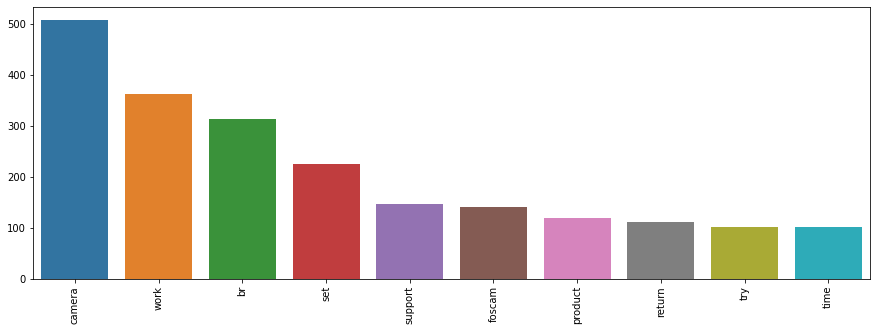

In [63]:
#Visualisation 
import matplotlib.pyplot as plt
import seaborn as sns
fig = plt.figure(figsize = (15,5))
sns.barplot(df.head(10).index.values.tolist(), df.head(10).values.tolist())
plt.xticks(rotation = 90)
plt.show()